In [1]:
import geopandas
import geopandas as gpd
import pandas as pd
from osgeo import ogr,gdal
import numpy 
from shapely.wkb import loads
from shapely.geometry import Point
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import openpyxl
import itertools
import networkx as nx
from simplify import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
gdal.SetConfigOption("OSM_CONFIG_FILE", "osmconf.ini")

# Define a helper function to generate pairs of consecutive elements in a list
def pairwise(iterable):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)
    
# Define a helper function to generate permutations
def permutations(iterable, r=None):
   # permutations('ABCD', 2) --> AB AC AD BA BC BD CA CB CD DA DB DC
    # permutations(range(3)) --> 012 021 102 120 201 210
    pool = tuple(iterable)
    n = len(pool)
    r = n if r is None else r
    if r > n:
        return
    indices = list(range(n))
    cycles = list(range(n, n-r, -1))
    yield tuple(pool[i] for i in indices[:r])
    while n:
        for i in reversed(range(r)):
            cycles[i] -= 1
            if cycles[i] == 0:
                indices[i:] = indices[i+1:] + indices[i:i+1]
                cycles[i] = n - i
            else:
                j = cycles[i]
                indices[i], indices[-j] = indices[-j], indices[i]
                yield tuple(pool[i] for i in indices[:r])
                break
        else:
            return 
        
# Retrive data from OSM and get the geographic data of tram
def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 

def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id']
    
    
    for a in keyCol: cl.append(a)
    if data is not None:
        for feature in sql_lyr:
            try:
                if feature.GetField(keyCol[0]) is not None:
                    shapely_geo = shapely.from_wkt(feature.geometry().ExportToWkt())
                    if shapely_geo is None:
                        continue
                    # field will become a row in the dataframe.
                    field = []
                    for i in cl: field.append(feature.GetField(i))
                    field.append(shapely_geo)   
                    features.append(field)
            except:
                print("WARNING: skipped OSM feature")
      
    cl.append('geometry')                   
    if len(features) > 0:
        return geopandas.GeoDataFrame(features,columns=cl) #,crs={'init': 'epsg:4326'}
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return geopandas.GeoDataFrame(columns=['osm_id','geometry']) #,crs={'init': 'epsg:4326'}    
    
def road(osm_path):
    
    return retrieve(osm_path,'lines',['highway'])  # ,**{'highway':["='tertiary'"]}


def public_stations(osm_path):
    
    return (retrieve(osm_path,'points',['public_transport', 'tram', 'subway', 'highway', 'bus', 'name']))

def bus_stations(osm_path):
    
    df_publich__transport_stations = public_stations(osm_path)
    
    bus_stations1 = df_publich__transport_stations.loc[df_publich__transport_stations.highway == 'bus_stop']
    
    bus_stations2 = df_publich__transport_stations.loc[df_publich__transport_stations.bus == 'yes']
    bus_stations2 = bus_stations2.loc[bus_stations2.public_transport == 'stop_position']
    
    bus_stations = pd.concat([bus_stations1, bus_stations2])
    
    bus_stations['geo_x'] = bus_stations.geometry.x
    bus_stations['geo_y'] = bus_stations.geometry.y   
        
    return bus_stations

def add_stations(net,station_file):
    
    station_geometries = pd.DataFrame(station_file.geometry)
    
    net.nodes = pd.concat([net.nodes,station_geometries]).reset_index(drop=True)
                           
    return net

# Pre-processing the geographic data of the subway network to obtain 'edges' and 'nodes'
def prepare_network(subway,station_file):
    """
    Prepare a subway network represented as a GeoDataFrame of LineString objects for routing.

    Args:
    - subway: a GeoDataFrame representing the subway network, with 'geometry' column containing LineString objects
    
    Returns:
    - a tuple of two DataFrames representing the edges and nodes of the prepared network

    Example:
    >>> import geopandas
    >>> subway = geopandas.read_file('subway.shp')
    >>> edges, nodes = prepare_network(subway)

    Note: This function requires the shapely, NetworkX, and Pandas libraries to be installed.
    """

    # Build a Network object from the subway edges
    net = Network(edges=subway)

    # Add endpoints to the network where edges don't intersect
    net = add_endpoints(net)
    
    # Add endpoints to the network where edges don't intersect
    net = add_stations(net,station_file)
        
    # Split edges at new endpoints
    net = split_edges_at_nodes(net)

    # Add new endpoints where edges were split
    net = add_endpoints(net)

    # Assign unique IDs to nodes and edges
    net = add_ids(net)

    # Add missing topology information to the network's edges
    net = add_topology(net)    

    # Calculate the degree of each node in the network
    net.nodes['degree'] = calculate_degree(net)

    # Merge edges with a degree of 2
    #net = merge_edges(net)

    # Drop duplicate edges
    net.edges = drop_duplicate_geometries(net.edges, keep='first') 

    # Reset node and edge IDs after fixing topology and merging edges
    net = reset_ids(net) 

    # Add edge distances
    net = add_distances(net)

    # Merge any MultiLineString edges
    net = merge_multilinestrings(net)

    # Add travel time for each edge based on distance and average speed
    net = add_travel_time(net)
    
    # Return the edges and nodes of the prepared network
    return net.edges, net.nodes

def expand_edges(edges):
    """
    Expand a DataFrame of edges into a format that can be used with network analysis algorithms.

    Args:
    - edges: a DataFrame containing edges with columns 'from_id', 'to_id', and 'distance'

    Returns:
    - a DataFrame containing expanded edges with columns 'from_id', 'to_id', 'distance', 'weights', 'to_from', and 'from_to'

    Example:
    >>> edges = pd.DataFrame({'from_id': [0, 0, 1], 'to_id': [1, 2, 2], 'distance': [1.5, 3.2, 2.8]})
    >>> expand_edges(edges)
      from_id  to_id  distance  weights  to_from  from_to
    0       0      1       1.5        1  (0, 1)  (1, 0)
    1       0      2       3.2        3  (0, 2)  (2, 0)
    2       1      2       2.8        2  (1, 2)  (2, 1)

    Notes:
    - The 'weights' column is created by rounding the 'distance' column to the nearest integer.
    - The 'to_from' and 'from_to' columns are created to facilitate conversion between edge formats.
    """
    # Round the distance to the nearest integer and store it in a new column 'weights'
    edges['weights'] = edges['distance'].astype(int)

    # Create 'to_from' and 'from_to' columns to facilitate conversion between edge formats
    edges['to_from'] = list(zip(edges.from_id, edges.to_id))
    edges['from_to'] = list(zip(edges.to_id, edges.from_id))

    # Return the expanded edges DataFrame
    return edges

In [3]:
def routes(osm_path):
    """
    Extracts route data from an OpenStreetMap file at the specified file path and returns it as a Pandas DataFrame.

    Parameters:
    osm_path (str): The file path of the OpenStreetMap file.

    Returns:
    Pandas DataFrame: A DataFrame containing route data extracted from the OpenStreetMap file.
    """

    # Call the 'retrieve' function to extract route data from the OpenStreetMap file
    # The 'retrieve' function takes three arguments:
    # - The file path of the OpenStreetMap file
    # - A list of geometry types to extract (in this case, only multilinestrings)
    # - A list of tag keys to extract (in this case, 'route', 'name', and 'ref')
    route_data = retrieve(osm_path, 'multilinestrings', ['route', 'to', 'name', 'ref', 'network', 'service'])#,'from'])

    # Return the extracted route data as a Pandas DataFrame
    return route_data

def bus_routes(osm_path):
    df_routes = routes(osm_path)
    bus_routes = pd.DataFrame(df_routes.loc[df_routes.route == 'bus'])
    return bus_routes

def sorted_routes(routes_file):     
    routes_file['ref'] = routes_file['ref'].astype(int)
    routes_file = routes_file.sort_values('ref')
    routes_file = routes_file.reset_index(drop=True)
    return routes_file

def check_to_column(sorted_routes_file, all_stations_file):
    
    def check_similarity(row):
        if row['to'] in all_stations_file['name'].values:
            return 'no need to revise'
        else:
            return row
    result = pd.DataFrame(sorted_routes_file.apply(check_similarity, axis=1))
    return result

def start_station_dict(routes_file):
    start_station_name_dict = {}
    for index, row in routes_file.iterrows():
        key = row['name']
        value = row['to']
        start_station_name_dict[key] = value
    return start_station_name_dict

def line_dict(routes_file):
    line_num_dict = {}
    for index, row in routes_file.iterrows():
        key = row['name']
        line_num_dict[key] = index
    return line_num_dict

def all_station_list(all_stations_file):
    all_stations_file= gpd.GeoDataFrame(all_stations_file.copy())
    all_stations_name = all_stations_file[['name', 'geometry', 'geo_x', 'geo_y']].reset_index(drop=True)
    return all_stations_name
    
# Sorting the stations on each route
def order_route(first_stop, unordered_route):
    new_order = []
    remaining_route = unordered_route.drop(unordered_route[unordered_route.name == first_stop.name.values[0]].index).reset_index(drop=True)
    tree = shapely.STRtree(remaining_route.geometry)
    new_order.append(first_stop)
    for iter_ in range(len(remaining_route)):
        try:
            if iter_ == 0:
                nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(first_stop.geometry)[0]]).T
                new_order.append(nearest_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.STRtree(remaining_route.geometry)
            elif iter_ == 1:
                second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
                new_order.append(second_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.STRtree(remaining_route.geometry)
            else:
                second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T
                new_order.append(second_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.STRtree(remaining_route.geometry)
        except TypeError:
            pass  # pass 'NoneType' object is not subscriptable Error
    return pd.concat(new_order).reset_index(drop=True)

def order_stations_inline(tram_line_dict,all_tram_stations_name,tram_routes,tram_start_station_name_dict):
    
    tram_stations_dict = tram_line_dict.copy()

    for key,value in tram_stations_dict.items():
        value1 = value
        value2 = all_tram_stations_name.loc[all_tram_stations_name.within(tram_routes.iloc[value1].geometry.buffer(0.0001))]
        value2['id'] = value2.reset_index().index
        tram_stations_dict[key] = value2[['id', 'name', 'geometry', 'geo_x', 'geo_y']].reset_index(drop=True)
    
    tram_stations_inorder_dict = tram_line_dict.copy()
    tram_order_route_dict = tram_line_dict.copy()

    for line in tram_stations_inorder_dict.keys():
        tram_stations_inorder = tram_stations_dict[line]
        for i in range(len(tram_stations_inorder)):
            if tram_stations_inorder.iloc[i]['name'] == tram_start_station_name_dict[line]:
                tram_stations_inorder_dict[line] = pd.DataFrame(tram_stations_inorder.iloc[i]).T
                print(tram_stations_inorder_dict[line])
        tram_order_route_dict[line] = order_route(tram_stations_inorder_dict[line], tram_stations_dict[line])

    return tram_order_route_dict

def s_e_coordinates_pairs(s_e_coordinates):
    """
    Given a Pandas DataFrame `s_e_coordinates` with columns `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, 
    and `e_coordinates_y`, returns a new DataFrame with columns `s_coordinates` and `e_coordinates`.
    
    `s_coordinates` and `e_coordinates` are each a tuple of the form `(x, y)`, where `x` is the value in the 
    `s_coordinates_x` or `e_coordinates_x` column, and `y` is the value in the `s_coordinates_y` or `e_coordinates_y` 
    column.
    
    Parameters
    ----------
    s_e_coordinates : pandas.DataFrame
        A DataFrame with columns `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, and `e_coordinates_y`.
    
    Returns
    -------
    pandas.DataFrame
        A new DataFrame with columns `s_coordinates` and `e_coordinates`.
    """
    
    # Create an empty DataFrame to hold the new columns
    s_e_coordinates_pairs = pd.DataFrame()
    
    # Create the `s_coordinates` column by zipping the `s_coordinates_x` and `s_coordinates_y` columns
    s_e_coordinates_pairs['s_coordinates'] = list(zip(s_e_coordinates.s_coordinates_x, s_e_coordinates.s_coordinates_y))
    
    # Create the `e_coordinates` column by zipping the `e_coordinates_x` and `e_coordinates_y` columns
    s_e_coordinates_pairs['e_coordinates'] = list(zip(s_e_coordinates.e_coordinates_x, s_e_coordinates.e_coordinates_y))
    
    # Return the new DataFrame
    return s_e_coordinates_pairs


# Define nearest nodes with real_world coordinates of start and end points, obtain the nearest id pairs of nodes 
def find_nearest_node(coordinate, nodes):
    """
    Find the nearest node to a given coordinate or geometry in a GeoDataFrame of nodes.

    Args:
    - coordinate: a tuple of longitude and latitude (in decimal degrees) or a shapely geometry object representing the location to search from
    - nodes: a GeoDataFrame containing nodes with a 'geometry' column representing their coordinates as shapely Point objects
    
    Returns:
    - the id value of the nearest node to the input coordinate or geometry

    Example:
    >>> import geopandas
    >>> from shapely.geometry import Point
    >>> from shapely import Geometry
    >>> nodes = geopandas.read_file('nodes.shp')
    >>> coordinate = (-122.3, 47.6)
    >>> find_nearest_node(coordinate, nodes)
    1234

    Note: This function requires the shapely and STRtree libraries to be installed.
    """
    # Build an STRtree index of the nodes' geometries for efficient nearest-neighbor search
    node_tree = shapely.STRtree(nodes.geometry)
   
    # Find the nearest node to the input coordinate or geometry using the STRtree index
    if isinstance(coordinate, tuple):
        find_nearest = node_tree.nearest(shapely.points(coordinate))
    elif isinstance(coordinate, shapely.lib.Geometry):
        find_nearest = node_tree.nearest(coordinate)
    
    # Return the id value of the nearest node from the nodes GeoDataFrame
    # print(nodes.iloc[find_nearest[1]]['id'])
    return int(nodes.iloc[find_nearest]['id'])

def id_pairs(coordinates_pairs, nodes):
    """
    Map the start and end coordinates to the nearest nodes in a transportation network.

    Args:
    - coordinates_pairs: a pandas DataFrame containing start and end coordinates in the network, with columns 's_coordinates', 'e_coordinates'
    - nodes: a GeoDataFrame containing nodes in the network, with a 'geometry' column representing their coordinates as shapely Point objects

    Returns:
    - a pandas DataFrame containing the nearest node IDs for each start and end coordinate pair, with columns 's_id', 'e_id'

    """
    # Initialize an empty DataFrame to store the start and end node IDs
    id_pairs = pd.DataFrame(columns=['s_id','e_id'])
    pairs_num = coordinates_pairs.shape[0]
    
    # For each start and end coordinate pair, find the nearest node in the network and store the node IDs in the DataFrame
    for i in range(pairs_num):
        s_coordinate = shapely.points(coordinates_pairs.s_coordinates[i])
        s_id = find_nearest_node(s_coordinate, nodes)
        e_coordinate = shapely.points(coordinates_pairs.e_coordinates[i])
        e_id = find_nearest_node(e_coordinate, nodes)
        id_pairs.loc[i] = [s_id,e_id]
        
    return id_pairs

def id_pairs_inline(tram_line_dict,tram_order_route_dict):
    tram_order_coordinates = tram_order_route_dict.copy()
    tram_order_coordinates = {key: value[['name', 'geo_x', 'geo_y']] for key, value in tram_order_coordinates.items()}

    # am_tram_order_coordinates

    new_dict = {}

    for key, value in tram_order_coordinates.items():
        shifted_value = pd.concat([value, value.shift(-1)], axis=1)
        shifted_value.columns = [f'col{i+1}' for i in range(len(value.columns))] + [f'col{i+4}' for i in range(len(value.columns))]
        new_dict[key] = shifted_value.dropna().reset_index(drop=True)
    
    tram_order_coordinates = {key: value[['col1', 'col4', 'col2', 'col3', 'col5', 'col6']] for key, value in new_dict.items()}

    for key, value in tram_order_coordinates.items():
        value.rename(columns={'col1': 's_name', 'col4': 'e_name','col2': 's_coordinates_x', 'col3': 's_coordinates_y', 'col5': 'e_coordinates_x', 'col6': 'e_coordinates_y'}, inplace=True)
    
    tram_order_coordinates_pairs = tram_order_coordinates.copy()
    tram_order_id_pairs = tram_order_coordinates.copy()

    for line in tram_order_coordinates.keys():
        tram_order_coordinates_pairs[line] = s_e_coordinates_pairs(tram_order_coordinates[line])
        tram_order_id_pairs[line] = id_pairs(tram_order_coordinates_pairs[line],nodes)
    
    return(tram_order_id_pairs)

In [4]:
# Create a base Graph object as the basic topology network with 'edges' and 'nodes'
def create_ground_graph(edges, nodes):
    """
    Create a networkx Graph object representing a ground transportation network.

    Args:
    - edges: a pandas DataFrame containing edges in the network, with columns 'from_id', 'to_id', and 'weights'
    - nodes: a GeoDataFrame containing nodes in the network, with a 'geometry' column representing their coordinates as shapely Point objects
    
    Returns:
    - a networkx Graph object representing the ground transportation network

    Example:
    >>> import pandas as pd
    >>> import geopandas as gpd
    >>> import networkx as nx
    >>> edges = pd.read_csv('edges.csv')
    >>> nodes = gpd.read_file('nodes.shp')
    >>> G = create_ground_graph(edges, nodes)

    Note: This function requires the pandas, geopandas, and networkx libraries to be installed.
    """
    # Extract the edges from the input DataFrame and create a list of tuples with weights
    od = edges[['from_id', 'to_id', 'weights']]
    edges_list = []
    for i, row in od.iterrows():
        weight_dict = {"weight": row[2]}
        tuple_row = (row[0], row[1], weight_dict)
        edges_list.append(tuple_row)
    
    # Extract the nodes from the input GeoDataFrame and create a list of node IDs
    nodes_list = nodes.iloc[:,2].tolist()
    
    # Create an empty Graph object and add the nodes and edges
    G = nx.Graph()
    G.add_nodes_from(nodes_list)
    G.add_edges_from(edges_list)
    
    return G

# Calculate the shorted path
def shortest_path(G, start_point_id, end_point_id, edges, weight = "weight"):   # calculate the shortest path for one start_end_node id_pair
    """
    Compute the shortest path between two nodes in a given graph, along with its length and the edges that belong to the path.

    Args:
    - G: a networkx Graph object representing the graph
    - start_point_id: the ID of the node where the path starts
    - end_point_id: the ID of the node where the path ends
    - weight: the attribute used to determine the weight of the edges in the graph (default: "weight")

    Returns:
    - a tuple containing:
        - the list of nodes that form the shortest path from start_point_id to end_point_id
        - the length of the shortest path
        - a pandas DataFrame containing the edges that belong to the shortest path, with a new column 'linewidth' that is proportional to the edge weights

    Example:
    >>> import networkx as nx
    >>> import pandas as pd
    >>> G = nx.Graph()
    >>> G.add_edge(0, 1, weight=2.0)
    >>> G.add_edge(1, 2, weight=1.0)
    >>> G.add_edge(0, 2, weight=3.0)
    >>> path, length, edges = shortest_path(G, 0, 2)
    >>> print(path)
    [0, 1, 2]
    >>> print(length)
    3.0
    >>> print(edges)
       from_id  to_id  weights  to_from  from_to  linewidth
    0        0      1      2.0      NaN      1.0        1.0
    2        1      2      1.0      2.0      NaN        1.0
    """
    
    # Compute the shortest path and its length using the networkx library
    path_s_e = nx.shortest_path(G, source=start_point_id, target=end_point_id, weight= weight)
    length_s_e = nx.shortest_path_length(G, source=start_point_id, target=end_point_id, weight= weight)
    
   
    # Select the edges that belong to the shortest path and compute their linewidth based on their weight
    short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
    #short_path_edges['linewidth'] = short_path_edges['weights'].apply(lambda x: np.ceil(x * 0.01 / 2))   # test 'linewidth' with one pair and there is no practical significance camparing with several routes and can be left out of the calculation 
    
    # Return the computed values as a tuple
    return path_s_e, length_s_e, short_path_edges

def all_shortest_paths(id_pairs,edges):
    """
    Find all shortest paths between start and end nodes and extract corresponding edges.

    Args:
    - id_pairs: a pandas DataFrame containing start and end node IDs for each path
    - edges: a pandas DataFrame containing edges in the network, with columns 'from_id', 'to_id', and 'weights'

    Returns:
    - shortest_path_pairs: a pandas DataFrame containing the edges for all shortest paths found

    Example:
    >>> shortest_path_pairs = all_shortest_paths(id_pairs, edges)

    Note: This function requires the pandas and networkx libraries to be installed.
    """
    row_num = id_pairs.shape[0]
    shortest_path_pairs = pd.DataFrame()
    
    for i in range(row_num):
        s_id = id_pairs.loc[i,'s_id']
        e_id = id_pairs.loc[i,'e_id']
        try:
            # Find shortest path between start and end nodes
            path_s_e = nx.shortest_path(G, source=s_id, target=e_id, weight= "weight")
            # Extract edges corresponding to shortest path
            short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
            shortest_path_pairs = pd.concat([shortest_path_pairs,short_path_edges])
        except nx.NetworkXNoPath:
            # If no path exists between start and end nodes, continue to next pair
            # print(f"No path found between {s_id} and {e_id}")
            continue
        #print(path_s_e, length_s_e)
        
    return shortest_path_pairs

# calculates the number of repetitions of each used edge and add the number to 'edges' with column of 'count_weight'
def edges_with_count_weight(shortest_path_pairs, edges):
    """
    Adds a 'count_weight' column to the edges dataframe to represent the number of times 
    each edge was used in the shortest paths. 
    Args:
        shortest_path_pairs (pandas.DataFrame): A DataFrame containing the edges that 
            are used in the shortest paths.
        edges (pandas.DataFrame): A DataFrame containing all the edges in the graph.
    Returns:
        A tuple of two DataFrames: 
            - shortest_path_edges (pandas.DataFrame): A DataFrame containing only the edges 
              used in the shortest paths and their corresponding 'count_weight' value.
            - edges (pandas.DataFrame): A DataFrame containing all the edges in the graph 
              and their corresponding 'count_weight' value.
    """
    shortest_path_edges = pd.DataFrame()
    shortest_path_pairs_duplicate_count = pd.DataFrame()
    
    # Copy the id of the edges that are used in the shortest paths to a new DataFrame
    shortest_path_pairs_duplicate_count['id'] = shortest_path_pairs['id']
    
    # Count the number of times each edge is used in the shortest paths
    duplicate_row_count = pd.DataFrame(shortest_path_pairs_duplicate_count[shortest_path_pairs_duplicate_count['id'].duplicated(keep=False)].value_counts(dropna=False))
    duplicate_row_count = duplicate_row_count.reset_index()
    duplicate_row_count.columns = ['id','count_weight']
    
    # Merge the 'count_weight' values with the original edges DataFrame
    edges = pd.merge(edges, duplicate_row_count, on='id', how='left')
    edges['count_weight'] = edges['count_weight'].fillna(1)
    # Merge the 'count_weight' values with the edges used in the shortest paths DataFrame
    shortest_path_edges = pd.merge(shortest_path_pairs,duplicate_row_count, on='id', how='left')
    shortest_path_edges['count_weight'] = shortest_path_edges['count_weight'].fillna(1)
    return duplicate_row_count, shortest_path_edges, edges

def plot_routes_even(routes_file, edges, shortest_path_edges):
    shortest_edges_list = list(shortest_path_edges.items())
    num_plots = len(routes_file) // 2
    colors = ['black', 'green', 'blue', 'orange', 'purple']
    fig, axes = plt.subplots(num_plots, 2, figsize=(30, 30))

    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            
            color = colors[i % len(colors)]

            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.4)
            gpd.GeoDataFrame(shortest_edges_list[i * 2][1].copy()).plot(ax=ax, zorder=1,
                                                                               linewidth=(shortest_edges_list[i * 2][
                                                                                               1].weights),
                                                                               color=color)
            ax.set_title(routes_file.iloc[i * 2]['name'])
        else:
            ax.axis('off')

        ax.axis('off')

    plt.show()

def plot_routes_odd(routes_file, edges, shortest_path_edges):
    shortest_edges_list = list(shortest_path_edges.items())
    num_plots = len(routes_file) // 2
    colors = ['black', 'green', 'blue', 'orange', 'purple']
    fig, axes = plt.subplots(num_plots, 2, figsize=(25, 25))

    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            
            color = colors[i % len(colors)]

            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.4)
            gpd.GeoDataFrame(shortest_edges_list[i * 2 + 1][1].copy()).plot(ax=ax, zorder=1,
                                                                               linewidth=(shortest_edges_list[i * 2 + 1][
                                                                                               1].weights),
                                                                               color=color)
            ax.set_title(routes_file.iloc[i * 2 + 1 ]['name'])
        else:
            ax.axis('off')

        ax.axis('off')

    plt.show()

## Step1: retrive all tram stations, edges and nodes from OSM map

In [5]:
#osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"
# osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.bbbike.pbf"
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.large.pbf"

In [6]:
city_bus_stations = bus_stations(osm_path)

In [7]:
city_bus_stations

,osm_id,public_transport,tram,subway,highway,bus,name,geometry,geo_x,geo_y
9,45989456,platform,None,None,bus_stop,yes,Nesserlaan,POINT (4.83890 52.27701),4.838900,52.277010
186,290955154,platform,None,None,bus_stop,yes,Badhoevelaan,POINT (4.79002 52.34049),4.790015,52.340489
238,311831619,platform,None,None,bus_stop,yes,Oostzanerdijk,POINT (4.88103 52.42043),4.881026,52.420431
239,311831882,platform,None,None,bus_stop,yes,Oostzanerdijk,POINT (4.88145 52.42022),4.881446,52.420219
243,318147070,platform,None,None,bus_stop,yes,Kometensingel,POINT (4.88289 52.41662),4.882885,52.416617
...,...,...,...,...,...,...,...,...,...,...
3846,10951641134,stop_position,None,None,None,yes,"Amsterdam, Dam",POINT (4.89149 52.37455),4.891493,52.374554
3847,10951641135,stop_position,None,None,None,yes,"Amsterdam, Museumplein",POINT (4.88082 52.35868),4.880820,52.358677
3850,10951641138,stop_position,None,None,None,yes,"Amsterdam, Parnassusweg",POINT (4.86883 52.33925),4.868826,52.339245
3851,10951641142,stop_position,None,None,None,yes,Arent Janszoon Ernststraat,POINT (4.86903 52.33164),4.869026,52.331642


In [8]:
city_bus_stations.to_excel('./city_bus_stations.xlsx',header = True, index = False)  

In [9]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))

# gpd.GeoDataFrame(city_bus_stations.copy()).plot(ax=ax,zorder=0)

In [10]:
city_bus = road(osm_path)

In [11]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))

# gpd.GeoDataFrame(city_bus.copy()).plot(ax=ax,zorder=0)

In [12]:
edges,nodes = prepare_network(city_bus,city_bus_stations)

topology: 100%|██████████████████████████████████████████████████████████████| 210450/210450 [00:24<00:00, 8746.40it/s]


In [13]:
edges = expand_edges(edges)

## Test 2-retrive routes, intersect the result with nodes to get stations on each route, then order the stations on each route and calculate the id pairs until shortest path

In [14]:
city_bus_routes = bus_routes(osm_path)
city_bus_routes = city_bus_routes.loc[city_bus_routes.network == 'Stadsvervoer Amsterdam']
city_bus_routes = city_bus_routes.loc[city_bus_routes.service != 'night']
city_bus_routes

,osm_id,route,to,name,ref,network,service,geometry
31,73789,bus,Amsterdam Muiderpoortstation,Bus 40: Amsterdam Amstelstation => Amsterdam M...,40,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.91869 52.34617, 4.91868 52..."
118,364188,bus,"Amsterdam, Station Zuid",Bus 65: Amsterdam KNSM Eiland => Amsterdam Sta...,65,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.91954 52.34665, 4.91944 52..."
120,364640,bus,"Amsterdam, Station Sloterdijk",Bus 22: Amsterdam Muiderpoortstation => Amster...,22,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.93372 52.36108, 4.93390 52..."
121,364642,bus,"Amsterdam, Muiderpoortstation",Bus 41: Amsterdam Station Holendrecht => Amste...,41,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.97617 52.32352, 4.97653 52..."
122,364648,bus,"Amsterdam, Station Zuid",Bus 15: Amsterdam Station Sloterdijk => Amster...,15,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83881 52.38771, 4.83870 52..."
...,...,...,...,...,...,...,...,...
840,11730319,bus,"Amsterdam, De Boelelaan",Bus 464: Amsterdam Gelderlandplein NO => Amste...,464,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87914 52.33186, 4.87914 52..."
841,11730320,bus,"Amsterdam, Anderlechtlaan",Bus 267: Amsterdam Riekerpolder => Amsterdam S...,267,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.82522 52.34015, 4.82543 52..."
842,11730321,bus,"Amsterdam, John M. Keynesplein",Bus 267: Amsterdam Sloten => Amsterdam Riekerp...,267,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.81431 52.33550, 4.81438 52..."
1067,12131095,bus,"Amsterdam, Centraal Station",Bus 43: Amsterdam Borneoeiland => Amsterdam Ce...,43,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.94671 52.37229, 4.94698 52..."


In [15]:
city_bus_routes = sorted_routes(city_bus_routes)
city_bus_routes

,osm_id,route,to,name,ref,network,service,geometry
0,4514662,bus,"Amsterdam, Station Sloterdijk",Bus 15: Amsterdam Station Zuid => Amsterdam St...,15,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87260 52.34084, 4.87241 52..."
1,364648,bus,"Amsterdam, Station Zuid",Bus 15: Amsterdam Station Sloterdijk => Amster...,15,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83881 52.38771, 4.83870 52..."
2,365436,bus,"Amsterdam, Louweshoek",Bus 18: Amsterdam Centraal Station => Amsterda...,18,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.90027 52.37972, 4.89945 52..."
3,4516350,bus,"Amsterdam, Centraal Station",Bus 18: Amsterdam Slotervaart => Amsterdam Cen...,18,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.82319 52.34629, 4.82319 52..."
4,4517357,bus,"Amsterdam, Centraal Station",Bus 21: Amsterdam Geuzenveld => Amsterdam Cent...,21,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.80073 52.37546, 4.80070 52..."
...,...,...,...,...,...,...,...,...
58,6900422,bus,Amsterdam Gelderlandplein NO,Bus 461: Amsterdam Gustav Mahlerplein => Amste...,461,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87311 52.33665, 4.87324 52..."
59,6900421,bus,"Amsterdam, Bolestein",Bus 463: Amsterdam Gelderlandplein Oost => Ams...,463,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87942 52.33081, 4.87942 52..."
60,6900419,bus,"Amsterdam, Gelderlandplein Noord",Bus 463: Amsterdam Bolestein => Amsterdam Geld...,463,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.85967 52.32498, 4.85967 52..."
61,11730318,bus,"Amsterdam, De Boelelaan",Bus 464: Amsterdam De Boelelaan/De Klencke => ...,464,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.88732 52.33438, 4.88756 52..."


In [16]:
need_revised_row = check_to_column(city_bus_routes, city_bus_stations)

In [17]:
need_revised_row.to_excel('./need_revised_row.xlsx',header = True, index = False)  

In [18]:
replacement_dict1 = {
    'Amsterdam, ': '',
    'Amsterdam': '',
    'Weesp Station': 'Station',
    'Osdorp De Aker': 'Matterhorn',
    'Schiphol, Airport/Plaza': 'Schiphol, Airport',
    'De Boelelaan': 'De Boelelaan/De Klencke'
}

city_bus_routes['to'] = city_bus_routes['to'].replace(replacement_dict1, regex=True).str.strip()
city_bus_routes = city_bus_routes.reset_index(drop=True)
city_bus_routes

,osm_id,route,to,name,ref,network,service,geometry
0,4514662,bus,Station Sloterdijk,Bus 15: Amsterdam Station Zuid => Amsterdam St...,15,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87260 52.34084, 4.87241 52..."
1,364648,bus,Station Zuid,Bus 15: Amsterdam Station Sloterdijk => Amster...,15,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.83881 52.38771, 4.83870 52..."
2,365436,bus,Louweshoek,Bus 18: Amsterdam Centraal Station => Amsterda...,18,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.90027 52.37972, 4.89945 52..."
3,4516350,bus,Centraal Station,Bus 18: Amsterdam Slotervaart => Amsterdam Cen...,18,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.82319 52.34629, 4.82319 52..."
4,4517357,bus,Centraal Station,Bus 21: Amsterdam Geuzenveld => Amsterdam Cent...,21,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.80073 52.37546, 4.80070 52..."
...,...,...,...,...,...,...,...,...
58,6900422,bus,Gelderlandplein NO,Bus 461: Amsterdam Gustav Mahlerplein => Amste...,461,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87311 52.33665, 4.87324 52..."
59,6900421,bus,Bolestein,Bus 463: Amsterdam Gelderlandplein Oost => Ams...,463,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.87942 52.33081, 4.87942 52..."
60,6900419,bus,Gelderlandplein Noord,Bus 463: Amsterdam Bolestein => Amsterdam Geld...,463,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.85967 52.32498, 4.85967 52..."
61,11730318,bus,De Boelelaan/De Klencke,Bus 464: Amsterdam De Boelelaan/De Klencke => ...,464,Stadsvervoer Amsterdam,None,"MULTILINESTRING ((4.88732 52.33438, 4.88756 52..."


In [19]:
replacement_dict = {
    'Amsterdam, ': '',
    'Amsterdam': '',

}

city_bus_stations['name'] = city_bus_stations['name'].replace(replacement_dict, regex=True).str.strip()

In [20]:
need_revised_row1 = check_to_column(city_bus_routes, city_bus_stations)

In [21]:
need_revised_row1.to_excel('./need_revised_row1.xlsx',header = True, index = False)  

In [22]:
city_bus_start_station_name_dict = start_station_dict(city_bus_routes)
city_bus_start_station_name_dict

{'Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk': 'Station Sloterdijk',
 'Bus 15: Amsterdam Station Sloterdijk => Amsterdam Station Zuid': 'Station Zuid',
 'Bus 18: Amsterdam Centraal Station => Amsterdam Slotervaart': 'Louweshoek',
 'Bus 18: Amsterdam Slotervaart => Amsterdam Centraal Station': 'Centraal Station',
 'Bus 21: Amsterdam Geuzenveld => Amsterdam Centraal Station': 'Centraal Station',
 'Bus 21: Amsterdam Centraal Station => Amsterdam Geuzenveld': 'Nolensstraat',
 'Bus 22: Amsterdam Muiderpoortstation => Amsterdam Station Sloterdijk': 'Station Sloterdijk',
 'Bus 22: Amsterdam Station Sloterdijk => Amsterdam Muiderpoortstation': 'Muiderpoortstation',
 'Bus 34: Amsterdam Olof Palmeplein => Amsterdam Noorderpark': 'Noorderpark',
 'Bus 34: Amsterdam Noorderpark => Amsterdam Olof Palmeplein': 'Olof Palmeplein',
 'Bus 35: Amsterdam Molenwijk => Amsterdam Olof Palmeplein': 'Olof Palmeplein',
 'Bus 35: Amsterdam Olof Palmeplein => Amsterdam Molenwijk': 'Molenwijk',


In [23]:
city_bus_line_dict = line_dict(city_bus_routes)

In [24]:
city_bus_line_dict

{'Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk': 0,
 'Bus 15: Amsterdam Station Sloterdijk => Amsterdam Station Zuid': 1,
 'Bus 18: Amsterdam Centraal Station => Amsterdam Slotervaart': 2,
 'Bus 18: Amsterdam Slotervaart => Amsterdam Centraal Station': 3,
 'Bus 21: Amsterdam Geuzenveld => Amsterdam Centraal Station': 4,
 'Bus 21: Amsterdam Centraal Station => Amsterdam Geuzenveld': 5,
 'Bus 22: Amsterdam Muiderpoortstation => Amsterdam Station Sloterdijk': 6,
 'Bus 22: Amsterdam Station Sloterdijk => Amsterdam Muiderpoortstation': 7,
 'Bus 34: Amsterdam Olof Palmeplein => Amsterdam Noorderpark': 8,
 'Bus 34: Amsterdam Noorderpark => Amsterdam Olof Palmeplein': 9,
 'Bus 35: Amsterdam Molenwijk => Amsterdam Olof Palmeplein': 10,
 'Bus 35: Amsterdam Olof Palmeplein => Amsterdam Molenwijk': 11,
 'Bus 36: Amsterdam Station Noord => Amsterdam Station Sloterdijk': 12,
 'Bus 36: Amsterdam Station Sloterdijk => Amsterdam Station Noord': 13,
 'Bus 37: Amsterdam Station Noord =>

In [25]:
city_bus_all_stations_name = all_station_list(city_bus_stations)

In [26]:
city_bus_all_stations_name

,name,geometry,geo_x,geo_y
0,Nesserlaan,POINT (4.83890 52.27701),4.838900,52.277010
1,Badhoevelaan,POINT (4.79002 52.34049),4.790015,52.340489
2,Oostzanerdijk,POINT (4.88103 52.42043),4.881026,52.420431
3,Oostzanerdijk,POINT (4.88145 52.42022),4.881446,52.420219
4,Kometensingel,POINT (4.88289 52.41662),4.882885,52.416617
...,...,...,...,...
3087,Dam,POINT (4.89149 52.37455),4.891493,52.374554
3088,Museumplein,POINT (4.88082 52.35868),4.880820,52.358677
3089,Parnassusweg,POINT (4.86883 52.33925),4.868826,52.339245
3090,Arent Janszoon Ernststraat,POINT (4.86903 52.33164),4.869026,52.331642


In [27]:
city_bus_all_stations_name.to_excel('./city_bus_all_stations_name.xlsx',header = True, index = False)  

In [28]:
city_bus_order_route_dict = order_stations_inline(city_bus_line_dict,city_bus_all_stations_name,city_bus_routes,city_bus_start_station_name_dict)

  id                name                      geometry     geo_x     geo_y
4  4  Station Sloterdijk  POINT (4.8388289 52.3877297)  4.838829  52.38773
    id                name                      geometry     geo_x      geo_y
30  30  Station Sloterdijk  POINT (4.8388077 52.3877091)  4.838808  52.387709
    id                name                      geometry     geo_x      geo_y
31  31  Station Sloterdijk  POINT (4.8387964 52.3878031)  4.838796  52.387803
    id          name                      geometry     geo_x      geo_y
16  16  Station Zuid  POINT (4.8725941 52.3408963)  4.872594  52.340896
    id          name                      geometry     geo_x     geo_y
17  17  Station Zuid  POINT (4.8727877 52.3406799)  4.872788  52.34068
    id          name                     geometry     geo_x      geo_y
30  30  Station Zuid  POINT (4.8737158 52.340699)  4.873716  52.340699
    id          name                      geometry     geo_x      geo_y
31  31  Station Zuid  POINT (4.8735724

In [29]:
city_bus_order_route_dict

{'Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk':     id                   name                      geometry     geo_x  \
 0   31     Station Sloterdijk  POINT (4.8387964 52.3878031)  4.838796   
 1    3     Bos en Lommerplein  POINT (4.8449423 52.3777943)  4.844942   
 2   41          Erasmusgracht  POINT (4.8469526 52.3763271)  4.846953   
 3   42    Jan van Galenstraat  POINT (4.8485665 52.3733267)  4.848566   
 4   25          Mercatorplein  POINT (4.8499526 52.3706797)  4.849953   
 5    8         W. Schoutenweg  POINT (4.8523338 52.3673843)  4.852334   
 6   39      W. Schoutenstraat  POINT (4.8523856 52.3673915)  4.852386   
 7   51             Postjesweg    POINT (4.853152 52.364773)  4.853152   
 8   53        Corantijnstraat  POINT (4.8532685 52.3617315)  4.853269   
 9   50          Surinameplein  POINT (4.8521842 52.3580689)  4.852184   
 10  47   Haarlemmermeerstraat  POINT (4.8503138 52.3554125)  4.850314   
 11  27         Hoofddorpplein  POINT (4.85038

In [30]:
city_bus_order_id_pairs = id_pairs_inline(city_bus_line_dict,city_bus_order_route_dict)
city_bus_order_id_pairs

{'Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk':       s_id    e_id
 0   136033  134735
 1   134735  136746
 2   136746  136747
 3   136747  135848
 4   135848  135196
 5   135196  136744
 6   136744  136791
 7   136791  136794
 8   136794  136787
 9   136787  136776
 10  136776  135915
 11  135915  136777
 12  136777  136779
 13  136779  136851
 14  136851  135407
 15  135407  135408
 16  135408  135993
 17  135993   27667,
 'Bus 15: Amsterdam Station Sloterdijk => Amsterdam Station Zuid':       s_id    e_id
 0    85542  135992
 1   135992  135188
 2   135188  135409
 3   135409  135406
 4   135406  136836
 5   136836  135868
 6   135868  135302
 7   135302  135492
 8   135492  135991
 9   135991  136787
 10  136787  135195
 11  135195  136792
 12  136792  135446
 13  135446  136745
 14  136745  136741
 15  136741  136748
 16  136748  135283
 17  135283  136749
 18  136749   49415,
 'Bus 18: Amsterdam Centraal Station => Amsterdam Slotervaart':       s_id    e_id
 0 

In [31]:
G = create_ground_graph(edges, nodes)

In [32]:
city_bus_shortest_path_pairs = city_bus_order_id_pairs.copy()
city_bus_duplicate_row_count = city_bus_order_id_pairs.copy()
city_bus_shortest_path_edges = city_bus_order_id_pairs.copy()
city_bus_edges = city_bus_order_id_pairs.copy()

for line in city_bus_order_id_pairs.keys():
    city_bus_shortest_path_pairs[line] = all_shortest_paths(city_bus_order_id_pairs[line],edges)

In [33]:
city_bus_shortest_path_pairs

{'Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk':           osm_id                                           geometry  \
 31027    7379311  LINESTRING (4.8405328 52.3861843, 4.8402543 52...   
 31252    7379505  LINESTRING (4.8437968 52.3782783, 4.8437477 52...   
 31254    7379512  LINESTRING (4.8444674 52.3779237, 4.8444949 52...   
 31270    7379536  LINESTRING (4.8444398 52.3818536, 4.8444628 52...   
 31273    7379543  LINESTRING (4.8444657 52.3807531, 4.8443583 52...   
 ...          ...                                                ...   
 48986   26982262  LINESTRING (4.868856 52.3407019, 4.8687748 52....   
 48987   26982266  LINESTRING (4.8686811 52.3406912, 4.8685547 52...   
 48991   26982270  LINESTRING (4.8685333 52.3408305, 4.8685173 52...   
 48992   26982271  LINESTRING (4.8685547 52.3406798, 4.8685333 52...   
 96139  277170888  LINESTRING (4.8683298 52.3425058, 4.8682898 52...   
 
              highway     id  from_id   to_id    distance      time 

In [43]:
city_bus_shortest_path_pairs = city_bus_order_id_pairs.copy()
city_bus_duplicate_row_count = city_bus_order_id_pairs.copy()
city_bus_shortest_path_edges = city_bus_order_id_pairs.copy()
city_bus_edges = city_bus_order_id_pairs.copy()

for line in city_bus_order_id_pairs.keys():
    city_bus_shortest_path_pairs[line] = all_shortest_paths(city_bus_order_id_pairs[line],edges)
    city_bus_duplicate_row_count[line], city_bus_shortest_path_edges[line], city_bus_edges[line] = edges_with_count_weight(city_bus_shortest_path_pairs[line],edges)

KeyError: 'id'

In [ ]:
city_bus_duplicate_row_count['Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk'], city_bus_shortest_path_edges['Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk'], city_bus_edges['Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk'] = edges_with_count_weight(city_bus_shortest_path_pairs['Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk'],edges)
# city_bus_shortest_path_pairs['Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk'] = all_shortest_paths(city_bus_order_id_pairs['Bus 15: Amsterdam Station Zuid => Amsterdam Station Sloterdijk'],edges)

In [ ]:
# Calculate the shorted path
def shortest_path(G, start_point_id, end_point_id, edges, weight = "weight"):   # calculate the shortest path for one start_end_node id_pair
    """
    Compute the shortest path between two nodes in a given graph, along with its length and the edges that belong to the path.

    Args:
    - G: a networkx Graph object representing the graph
    - start_point_id: the ID of the node where the path starts
    - end_point_id: the ID of the node where the path ends
    - weight: the attribute used to determine the weight of the edges in the graph (default: "weight")

    Returns:
    - a tuple containing:
        - the list of nodes that form the shortest path from start_point_id to end_point_id
        - the length of the shortest path
        - a pandas DataFrame containing the edges that belong to the shortest path, with a new column 'linewidth' that is proportional to the edge weights

    Example:
    >>> import networkx as nx
    >>> import pandas as pd
    >>> G = nx.Graph()
    >>> G.add_edge(0, 1, weight=2.0)
    >>> G.add_edge(1, 2, weight=1.0)
    >>> G.add_edge(0, 2, weight=3.0)
    >>> path, length, edges = shortest_path(G, 0, 2)
    >>> print(path)
    [0, 1, 2]
    >>> print(length)
    3.0
    >>> print(edges)
       from_id  to_id  weights  to_from  from_to  linewidth
    0        0      1      2.0      NaN      1.0        1.0
    2        1      2      1.0      2.0      NaN        1.0
    """
    
    # Compute the shortest path and its length using the networkx library
    path_s_e = nx.shortest_path(G, source=start_point_id, target=end_point_id, weight= weight)
    length_s_e = nx.shortest_path_length(G, source=start_point_id, target=end_point_id, weight= weight)
    
   
    # Select the edges that belong to the shortest path and compute their linewidth based on their weight
    short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
    #short_path_edges['linewidth'] = short_path_edges['weights'].apply(lambda x: np.ceil(x * 0.01 / 2))   # test 'linewidth' with one pair and there is no practical significance camparing with several routes and can be left out of the calculation 
    
    # Return the computed values as a tuple
    return path_s_e, length_s_e, short_path_edges

def all_shortest_paths(id_pairs,edges):
    """
    Find all shortest paths between start and end nodes and extract corresponding edges.

    Args:
    - id_pairs: a pandas DataFrame containing start and end node IDs for each path
    - edges: a pandas DataFrame containing edges in the network, with columns 'from_id', 'to_id', and 'weights'

    Returns:
    - shortest_path_pairs: a pandas DataFrame containing the edges for all shortest paths found

    Example:
    >>> shortest_path_pairs = all_shortest_paths(id_pairs, edges)

    Note: This function requires the pandas and networkx libraries to be installed.
    """
    row_num = id_pairs.shape[0]
    shortest_path_pairs = pd.DataFrame()
    
    for i in range(row_num):
        s_id = id_pairs.loc[i,'s_id']
        e_id = id_pairs.loc[i,'e_id']
        try:
            # Find shortest path between start and end nodes
            path_s_e = nx.shortest_path(G, source=s_id, target=e_id, weight= "weight")
            # Extract edges corresponding to shortest path
            short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
            shortest_path_pairs = pd.concat([shortest_path_pairs,short_path_edges])
        except nx.NetworkXNoPath:
            # If no path exists between start and end nodes, continue to next pair
            # print(f"No path found between {s_id} and {e_id}")
            continue
        #print(path_s_e, length_s_e)
        
    return shortest_path_pairs

# calculates the number of repetitions of each used edge and add the number to 'edges' with column of 'count_weight'
def edges_with_count_weight(shortest_path_pairs, edges):
    """
    Adds a 'count_weight' column to the edges dataframe to represent the number of times 
    each edge was used in the shortest paths. 
    Args:
        shortest_path_pairs (pandas.DataFrame): A DataFrame containing the edges that 
            are used in the shortest paths.
        edges (pandas.DataFrame): A DataFrame containing all the edges in the graph.
    Returns:
        A tuple of two DataFrames: 
            - shortest_path_edges (pandas.DataFrame): A DataFrame containing only the edges 
              used in the shortest paths and their corresponding 'count_weight' value.
            - edges (pandas.DataFrame): A DataFrame containing all the edges in the graph 
              and their corresponding 'count_weight' value.
    """
    shortest_path_edges = pd.DataFrame()
    shortest_path_pairs_duplicate_count = pd.DataFrame()
    
    # Copy the id of the edges that are used in the shortest paths to a new DataFrame
    shortest_path_pairs_duplicate_count['id'] = shortest_path_pairs['id']
    
    # Count the number of times each edge is used in the shortest paths
    duplicate_row_count = pd.DataFrame(shortest_path_pairs_duplicate_count[shortest_path_pairs_duplicate_count['id'].duplicated(keep=False)].value_counts(dropna=False))
    duplicate_row_count = duplicate_row_count.reset_index()
    duplicate_row_count.columns = ['id','count_weight']
    
    # Merge the 'count_weight' values with the original edges DataFrame
    edges = pd.merge(edges, duplicate_row_count, on='id', how='left')
    edges['count_weight'] = edges['count_weight'].fillna(1)
    # Merge the 'count_weight' values with the edges used in the shortest paths DataFrame
    shortest_path_edges = pd.merge(shortest_path_pairs,duplicate_row_count, on='id', how='left')
    shortest_path_edges['count_weight'] = shortest_path_edges['count_weight'].fillna(1)
    return duplicate_row_count, shortest_path_edges, edges

AttributeError: 'DataFrame' object has no attribute 'weights'

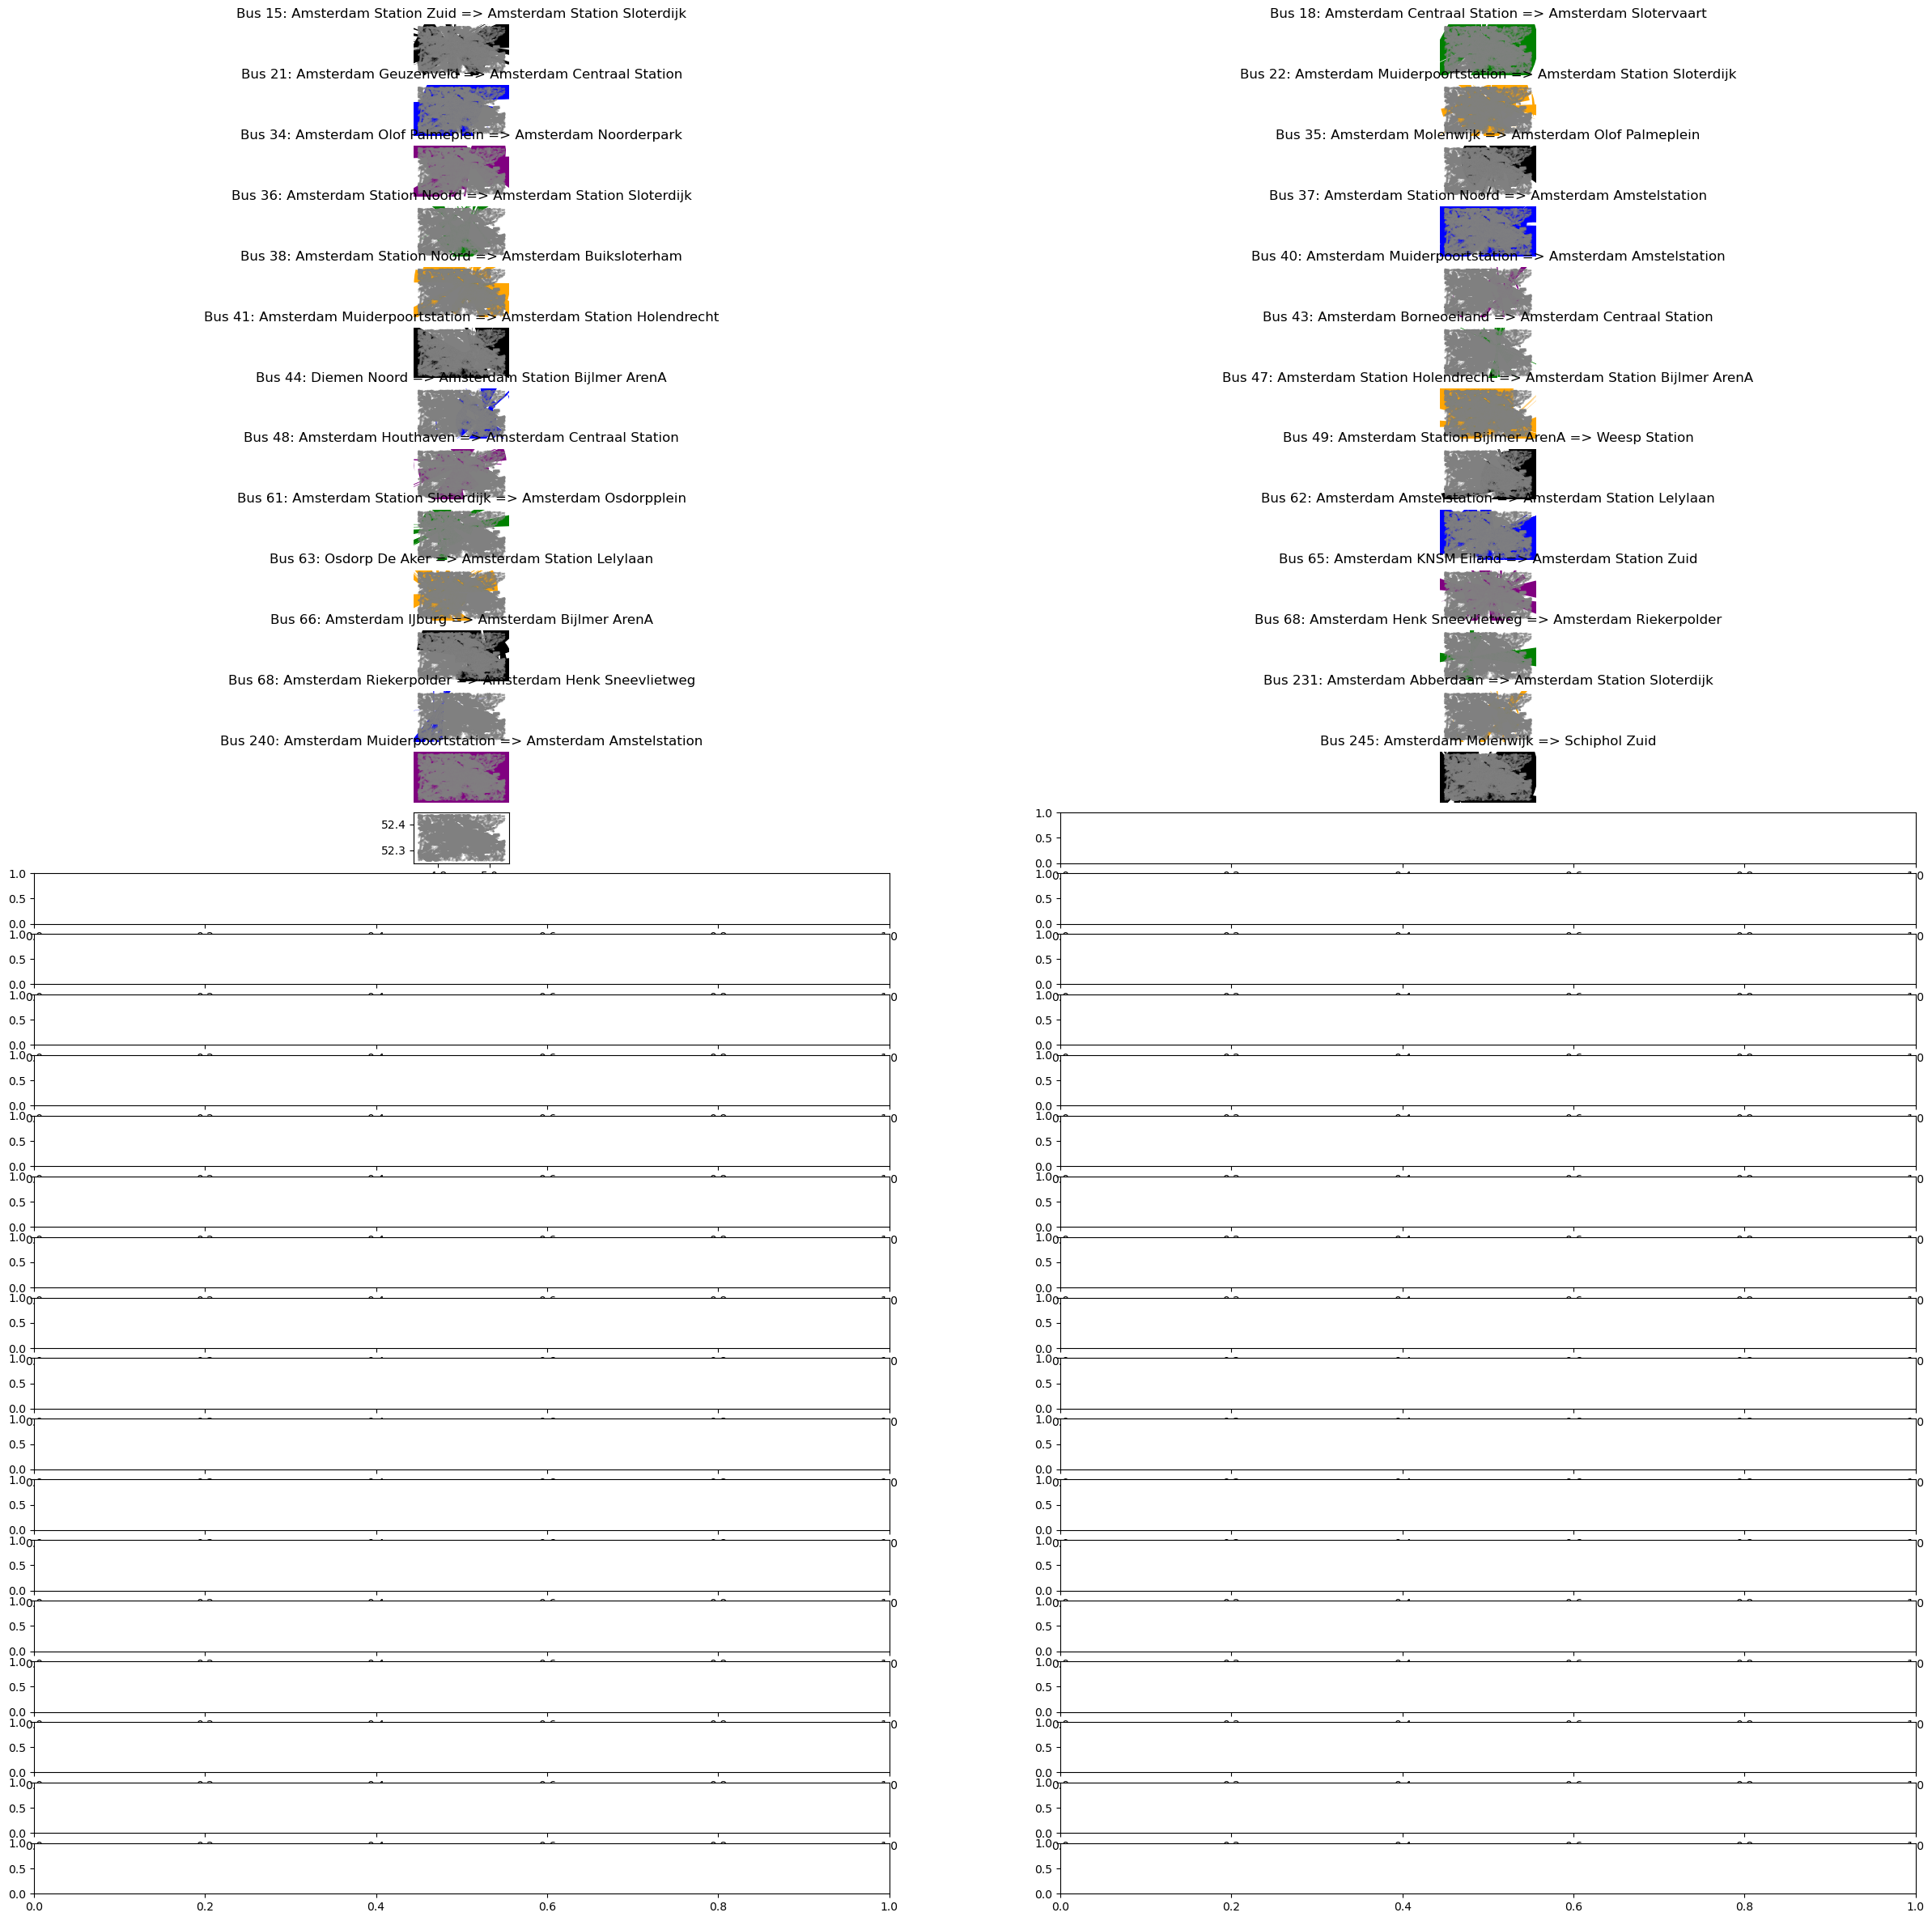

In [48]:
plot_routes_even(city_bus_routes,edges,city_bus_shortest_path_pairs)

In [ ]:
plot_routes_odd(city_bus_routes,edges,city_bus_shortest_path_pairs)

In [ ]:
am_tram_shortest_path_pairs = am_tram_order_id_pairs.copy()
duplicate_row_count = am_tram_order_id_pairs.copy()
am_tram_shortest_path_edges = am_tram_order_id_pairs.copy()
am_tram_edges = am_tram_order_id_pairs.copy()

for line in am_tram_order_id_pairs.keys():
    am_tram_shortest_path_pairs[line] = all_shortest_paths(am_tram_order_id_pairs[line],edges)
    duplicate_row_count[line], am_tram_shortest_path_edges[line], am_tram_edges[line] = edges_with_count_weight(am_tram_shortest_path_pairs[line],edges)

In [ ]:
plot_routes_even(am_tram_routes,edges,am_tram_shortest_path_edges)

In [ ]:
plot_routes_odd(am_tram_routes,edges,am_tram_shortest_path_edges)

In [ ]:
am_tram_shortest_edges_list = list(am_tram_shortest_path_edges.items())

In [ ]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))

for i, ax in enumerate(axes.flat):
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='black')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='purple')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='red')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='brown')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='black')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='green')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='blue')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='orange')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='purple')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='red')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='brown')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()
    

In [ ]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))

for i, ax in enumerate(axes.flat):
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='black')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='purple')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='red')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='brown')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='black')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='green')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='blue')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='orange')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='purple')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='red')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='brown')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()
    

Tram4 on OSM is different from it on GVB website, this research is based on OSM.

In [ ]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))

# gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
# gpd.GeoDataFrame(am_tram_shortest_path_edges['am_tram_line4_0'].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges['am_tram_line4_0'].count_weight)*2,color='orange')
# ax.set_title('Route 4')